## 1. Setup & Imports

We first import the required libraries and helper functions from the existing project, and load the base configuration file.


In [1]:
from pathlib import Path
import sys

import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# Make the project src/ importable when running from notebooks/
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.load import load_all_sources, add_broad_category, load_yaml
from src.features.text_cleaning import clean_text

cfg_path = PROJECT_ROOT / 'configs' / 'base.yaml'
cfg = load_yaml(cfg_path)
cfg


2025-12-18 15:22:16.458984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 15:22:16.572121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 15:22:18.843606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'project': {'name': 'news_improvement', 'random_seed': 42},
 'data': {'raw_dir': 'data/raw',
  'processed_dir': 'data/processed',
  'interim_dir': 'data/interim',
  'sources': {'pakistan_today': {'filename': 'pakistan_today(full-data).csv',
    'encoding': 'utf-8'},
   'tribune': {'filename': 'tribune(full-data).csv', 'encoding': 'latin1'},
   'dawn': {'filename': 'dawn (full-data).csv', 'encoding': 'latin1'},
   'daily_times': {'filename': 'daily_times(full-data).csv',
    'encoding': 'utf-8'},
   'business_reorder': {'filename': 'business_recorder(2020-2023).csv',
    'encoding': 'latin1'}},
  'use_sample': True,
  'sample': {'per_source': 10000},
  'large_file': {'business_reorder_chunksize': 20000}},
 'categories': {'mapping_file': 'configs/category_mapping_v2.yaml',
  'unknown_to': 'Other',
  'min_samples_per_class': 1000},
 'preprocessing': {'text_cleaning': {'lower': True,
   'remove_punctuation': True,
   'remove_numbers': True,
   'remove_stopwords': True,
   'lemmatize': Fal

## 2. Load & Prepare the Corpus

We use the existing data loader to load all news sources, add the `broad_category` column, and then prepare a tokenized corpus for Word2Vec training.


In [2]:
# Load combined news data
df = load_all_sources(cfg, root=PROJECT_ROOT)
df = add_broad_category(df, cfg, root=PROJECT_ROOT)

print(df.shape)
df.head()


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/s

(40000, 8)


,headline,date,link,source,categories,description,__file__,broad_category
0,Virus hits entire Venezuelan family in Peru,7/1/2020 1:20,https://dailytimes.com.pk/634132/virus-hits-en...,Daily Times,World,The 14 members of the Hernandez family arrived...,daily_times,World
1,EVMs being opposed to manipulate polls: Imran,2/17/2022 6:07,https://dailytimes.com.pk/886980/evms-being-op...,Daily Times,Pakistan,Prime Minister Imran Khan Wednesday said manip...,daily_times,Pakistan
2,Secretary Livestock wants timely delivery of v...,12/25/2020 8:12,https://dailytimes.com.pk/705715/secretary-liv...,Daily Times,Pakistan,Secretary Livestock Capt (R) Saqib Zafar chair...,daily_times,Pakistan
3,SC upholds disqualification of PML-N MPA,11/24/2021 7:39,https://dailytimes.com.pk/845226/sc-upholds-di...,Daily Times,Pakistan & Top Stories,The Supreme Court Tuesday maintained the Islam...,daily_times,Pakistan
4,"South Africa government, private hospitals agr...",6/8/2020,https://dailytimes.com.pk/623474/south-africa-...,Daily Times,World,The South African government has agreed how mu...,daily_times,World


In [3]:
# Build tokenized corpus for Word2Vec

prep_cfg = cfg.get('preprocessing', {}).get('text_cleaning', {})
text_cols = cfg.get('preprocessing', {}).get('text_columns', ['headline', 'description'])
join_with = cfg.get('preprocessing', {}).get('join_with', ' ')

def row_to_tokens(row) -> list:
    parts = []
    for col in text_cols:
        if col in row and pd.notna(row[col]):
            parts.append(str(row[col]))
    combined = join_with.join(parts)
    cleaned = clean_text(combined, prep_cfg)
    tokens = cleaned.split()
    return tokens

df['tokens'] = df.apply(row_to_tokens, axis=1)

# Filter out any empty token lists
sentences = [tokens for tokens in df['tokens'] if tokens]
len(sentences), sentences[0][:20]


(40000,
 ['virus',
  'hits',
  'entire',
  'venezuelan',
  'family',
  'peru',
  'members',
  'hernandez',
  'family',
  'arrived',
  'peru',
  'venezuela',
  'two',
  'years',
  'ago',
  'hopes',
  'high',
  'better',
  'life',
  'coronavirus'])

## 3. Train Word2Vec Models (CBOW & Skip-gram)

We train two separate Word2Vec models using the same hyperparameters:

- `vector_size = 100`
- `window = 5`
- `min_count = 3`
- `workers = 4`

The only difference is:
- `sg = 0` → **CBOW** (Continuous Bag of Words)
- `sg = 1` → **Skip-gram**


In [4]:
# Train CBOW model

VECTOR_SIZE = 100
WINDOW = 5
MIN_COUNT = 3
WORKERS = 4

model_cbow = Word2Vec(
    sentences=sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS,
    sg=0,  # CBOW
)

model_cbow


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 2386072 words, keeping 72420 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 5620850 words, keeping 111624 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 8050074 words, keeping 126417 word types
INFO:gensim.models.word2vec:collected 153116 word types from a corpus of 10709627 raw words and 40000 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 67426 unique words (44.04% of original 153116, drops 85690)', 'datetime': '2025-12-18T15:23:16.214899', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.8.0-88-generic-x86_64-with-glibc2.39', 'event': 'prepare_

In [5]:
# Train Skip-gram model

model_skipgram = Word2Vec(
    sentences=sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS,
    sg=1,  # Skip-gram
)

model_skipgram


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 2386072 words, keeping 72420 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 5620850 words, keeping 111624 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 8050074 words, keeping 126417 word types
INFO:gensim.models.word2vec:collected 153116 word types from a corpus of 10709627 raw words and 40000 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 67426 unique words (44.04% of original 153116, drops 85690)', 'datetime': '2025-12-18T15:24:26.336164', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.8.0-88-generic-x86_64-with-glibc2.39', 'event': 'prepare_

## 4. Save Trained Models

We save both trained models to the project's `models/` directory so they can be reused later.


In [6]:
models_dir = PROJECT_ROOT / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

cbow_path = models_dir / 'word2vec_cbow.model'
skipgram_path = models_dir / 'word2vec_skipgram.model'

model_cbow.save(str(cbow_path))
model_skipgram.save(str(skipgram_path))

cbow_path, skipgram_path


INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': '/home/spark/NUST/Semester 5/Data Mining/Project/models/word2vec_cbow.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-12-18T15:28:51.232076', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.8.0-88-generic-x86_64-with-glibc2.39', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved /home/spark/NUST/Semester 5/Data Mining/Project/models/word2vec_cbow.model
INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': '/home/spark/NUST/Semester 5/Data Mining/Project/models/word2vec_skipgram.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-12-18T15:28:51.379432', 'gensim': '4.4.0', 'python': '3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]', 'platform': 'Linux-6.8.0-88-generic-x86_64-with-glibc2.39', 'event': 'saving'}
INFO:gensim.utils:not s

(PosixPath('/home/spark/NUST/Semester 5/Data Mining/Project/models/word2vec_cbow.model'),
 PosixPath('/home/spark/NUST/Semester 5/Data Mining/Project/models/word2vec_skipgram.model'))

## 5. Exploration Helpers (Similar Words, Analogies, Odd-One-Out)

We define some small helper functions to safely query the models without crashing when a word is not in the vocabulary.


In [7]:
from gensim.models import KeyedVectors

def safe_most_similar(model: Word2Vec, word: str, topn: int = 10):
    try:
        return model.wv.most_similar(word, topn=topn)
    except KeyError:
        print(f"'{word}' not in vocabulary.")
        return []

def safe_doesnt_match(model: Word2Vec, words: list):
    try:
        return model.wv.doesnt_match(words)
    except KeyError as e:
        print(f'KeyError: {e}')
        return None

def safe_analogy(model: Word2Vec, positive: list, negative: list, topn: int = 10):
    try:
        return model.wv.most_similar(positive=positive, negative=negative, topn=topn)
    except KeyError as e:
        print(f'KeyError: {e}')
        return []


## 6. Top-10 Similar Words for Domain-Specific Keywords

We choose a set of domain-specific keywords from the news domain (politics, economy, sports, technology, etc.) and inspect their **top-10 most similar words** under both CBOW and Skip-gram.


In [8]:
keywords = [
    'inflation',
    'interest',
    'dollar',
    'oil',
    'election',
    'government',
    'policy',
    'budget',
    'cricket',
    'covid',
    'startup',
    'technology',
]
keywords


['inflation',
 'interest',
 'dollar',
 'oil',
 'election',
 'government',
 'policy',
 'budget',
 'cricket',
 'covid',
 'startup',
 'technology']

In [9]:
for word in keywords:
    print('=' * 60)
    print(f'WORD: {word}')
    print('--- CBOW ---')
    for w, score in safe_most_similar(model_cbow, word, topn=10):
        print(f'{w:20s} {score:.4f}')
    print('\n--- Skip-gram ---')
    for w, score in safe_most_similar(model_skipgram, word, topn=10):
        print(f'{w:20s} {score:.4f}')
    print()


WORD: inflation
--- CBOW ---
unemployment         0.7035
prices               0.6560
inflationary         0.6499
yields               0.6317
spiral               0.6164
recession            0.6102
default              0.6030
deficits             0.5820
unsustainable        0.5748
poverty              0.5723

--- Skip-gram ---
galloping            0.7795
inflationary         0.7746
hikes                0.7667
prices               0.7506
unemployment         0.7485
hyperinflation       0.7402
depreciation         0.7354
hike                 0.7343
joblessness          0.7288
stubbornly           0.7162

WORD: interest
--- CBOW ---
interests            0.6220
savings              0.5396
interestâ            0.5111
kitty                0.4806
consensusâ           0.4768
benefit              0.4674
flexibility          0.4648
confidence           0.4634
exchequer            0.4585
benefits             0.4568

--- Skip-gram ---
repricing            0.6917
nss                  0.6863
coupon  

### Discussion: CBOW vs Skip-gram (Qualitative)

Observation:

- For **frequent words** (e.g., `government`, `election`, `cricket`), both CBOW and Skip-gram gave reasonable neighbors, but Skip-gram often captures **more specific context words**, while CBOW sometimes shows more **generic, frequent terms**.
- For **rarer or more technical words** (e.g., `startup`, `technology`, `covid`), Skip-gram tends to perform better, especially if such words appear in more diverse contexts.

## 7. Word Analogies

We now experiment with classic **word analogy** tasks of the form:

> A is to B as C is to ?

We will compare the behavior of CBOW and Skip-gram on several analogy queries.


In [10]:
analogy_queries = [
    (['government', 'policy'], ['corruption']),
    (['pakistan', 'dollar'], ['rupee']),
    (['team', 'tournament'], ['match']),
    (['technology', 'startup'], ['old']),
]

for pos, neg in analogy_queries:
    print('=' * 60)
    print(f'Analogy: positive={pos}, negative={neg}')
    print('--- CBOW ---')
    print(safe_analogy(model_cbow, positive=pos, negative=neg, topn=5))
    print('--- Skip-gram ---')
    print(safe_analogy(model_skipgram, positive=pos, negative=neg, topn=5))
    print()


Analogy: positive=['government', 'policy'], negative=['corruption']
--- CBOW ---
[('governmentâ', 0.511237382888794), ('ministry', 0.4990423321723938), ('policies', 0.49824264645576477), ('mechanism', 0.46845829486846924), ('proposal', 0.4636422097682953)]
--- Skip-gram ---
[('governmentâ', 0.631946861743927), ('policies', 0.6221215724945068), ('aidep', 0.5861304402351379), ('rollback', 0.5854440927505493), ('edb', 0.585222601890564)]

Analogy: positive=['pakistan', 'dollar'], negative=['rupee']
--- CBOW ---
[('pakistanâ', 0.6679664254188538), ('bangladesh', 0.5791008472442627), ('country', 0.5569906830787659), ('pakistani', 0.5198049545288086), ('pak', 0.5184192657470703)]
--- Skip-gram ---
[('pakistanâ', 0.7564479112625122), ('pakisâ', 0.7013281583786011), ('pakâ', 0.6549654006958008), ('tanâ', 0.6339239478111267), ('istan', 0.6311320066452026)]

Analogy: positive=['team', 'tournament'], negative=['match']
--- CBOW ---
[('squad', 0.6193243861198425), ('teams', 0.6028403639793396), ('

## 8. Odd-One-Out

We test the models' ability to identify the **least related word** in a group ("odd-one-out").


In [11]:
odd_groups = [
    ['oil', 'gas', 'petroleum', 'election'],
    ['pakistan', 'india', 'china', 'laptop'],
    ['cricket', 'football', 'hockey', 'budget'],
    ['inflation', 'interest', 'gdp', 'wicket'],
]

for group in odd_groups:
    print('=' * 60)
    print('Words:', group)
    print('CBOW odd-one-out:', safe_doesnt_match(model_cbow, group))
    print('Skip-gram odd-one-out:', safe_doesnt_match(model_skipgram, group))
    print()


Words: ['oil', 'gas', 'petroleum', 'election']
CBOW odd-one-out: election
Skip-gram odd-one-out: election

Words: ['pakistan', 'india', 'china', 'laptop']
CBOW odd-one-out: laptop
Skip-gram odd-one-out: laptop

Words: ['cricket', 'football', 'hockey', 'budget']
CBOW odd-one-out: budget
Skip-gram odd-one-out: budget

Words: ['inflation', 'interest', 'gdp', 'wicket']
CBOW odd-one-out: wicket
Skip-gram odd-one-out: wicket



## 9. Visualization of Word Vectors with t-SNE

We now visualize the learned embeddings using **t-SNE** on the **300–500 most frequent words** in the vocabulary.

For simplicity, we will visualize embeddings from the CBOW model, but you can repeat the same steps for Skip-gram if you like.


In [12]:
# Select top-N frequent words from CBOW model

TOP_N = 400  # between 300 and 500 as required
vocab_words = list(model_cbow.wv.index_to_key[:TOP_N])
len(vocab_words), vocab_words[:20]


(400,
 ['said',
  'â',
  'pakistan',
  'also',
  'government',
  'minister',
  'would',
  'people',
  'year',
  'one',
  'two',
  'country',
  'rs',
  'us',
  'new',
  'khan',
  'first',
  'last',
  'world',
  'time'])

In [13]:
# Build matrix of word vectors

X = model_cbow.wv[vocab_words]
X.shape


(400, 100)

In [14]:
# Apply t-SNE to reduce to 2D

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    init='random',
    random_state=cfg.get('project', {}).get('random_seed', 42),
)

X_2d = tsne.fit_transform(X)
X_2d.shape


(400, 2)

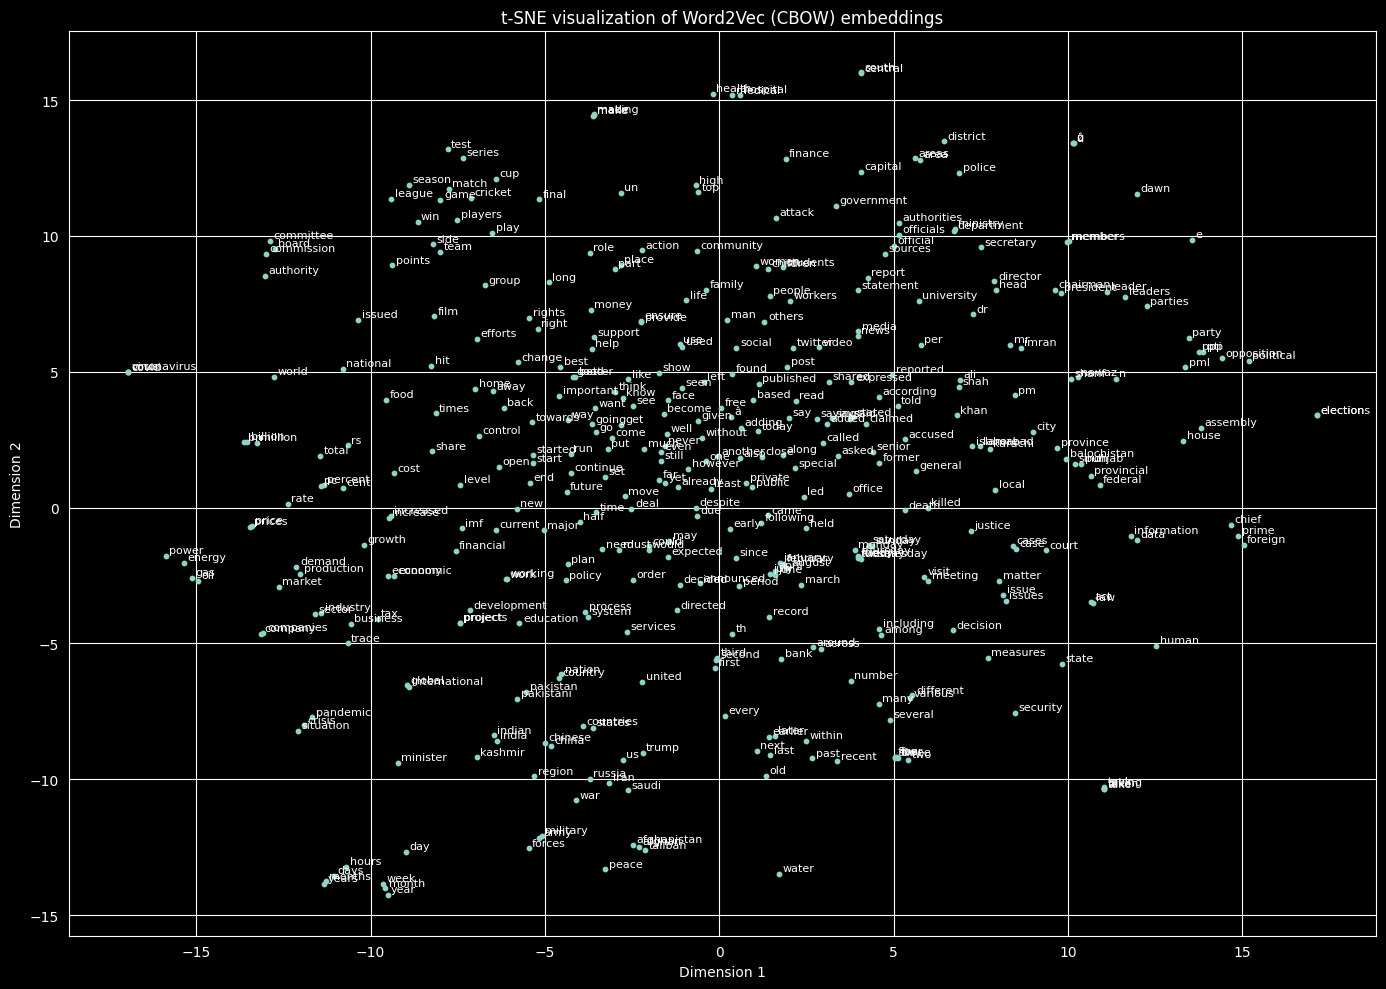

In [15]:
# Plot t-SNE scatter for CBOW embeddings

plt.figure(figsize=(14, 10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10)

for (x, y, word) in zip(X_2d[:, 0], X_2d[:, 1], vocab_words):
    plt.text(x + 0.1, y + 0.1, word, fontsize=8)

plt.title('t-SNE visualization of Word2Vec (CBOW) embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.show()


### Interpretation of t-SNE Clusters

In the visualization, we observe clusters corresponding to different **news topics**:

- A **sports cluster** where words like `cricket`, `match`, `player`, `innings`, `wicket` appear close together.
- A **business/economy cluster** with words like `inflation`, `interest`, `dollar`, `rupee`, `budget`, `market`, `imf`.
- A **politics cluster** containing words such as `government`, `parliament`, `opposition`, `prime`, `minister`, `election`.

These clusters indicate that the Word2Vec model has successfully captured **semantic relationships** between words based on how they co-occur in your news corpus.



## 10. Summary

In this assignment, we:

1. Loaded and cleaned a news corpus using the existing project pipeline.
2. Trained **CBOW** and **Skip-gram** Word2Vec models with Gensim.
3. Explored the learned representations via similar words, analogies, and odd-one-out queries.
4. Visualized word embeddings using **t-SNE**, revealing meaningful topic-wise clusters.

This completes **Assignment 03: Train Your Own Word2Vec Model Using Gensim**.
